#  End-to-end Multil-class Dog Breed Classification
This notebook demonstrates the creation of a complete multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem Statement
Determining the dog breed from an image of a dog.

## 2. Data
We're utilizing data sourced from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
Here's some key information about the data:

- We're working with images, which are unstructured data, suggesting that deep learning or transfer learning methods are most suitable.
- There are 120 distinct breeds of dogs, meaning there are 120 different classes for classification.
- The training set consists of over 10,000 images, each with corresponding labels indicating the breed.
- The test set also contains over 10,000 images, but these images lack labels, as our goal is to predict their respective breeds.


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle competitions download -c dog-breed-identification

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dog-breed-identification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# import TensirFlow as tf
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:",tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availavility
print("GPU", "available YESSS!!!" if tf.config.list_physical_devices("GPU") else "Not available :(")

TF version: 2.15.0
TF Hub version: 0.16.1
GPU Not available :(


## Preparing our data (converting it into Tensors)

In [8]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

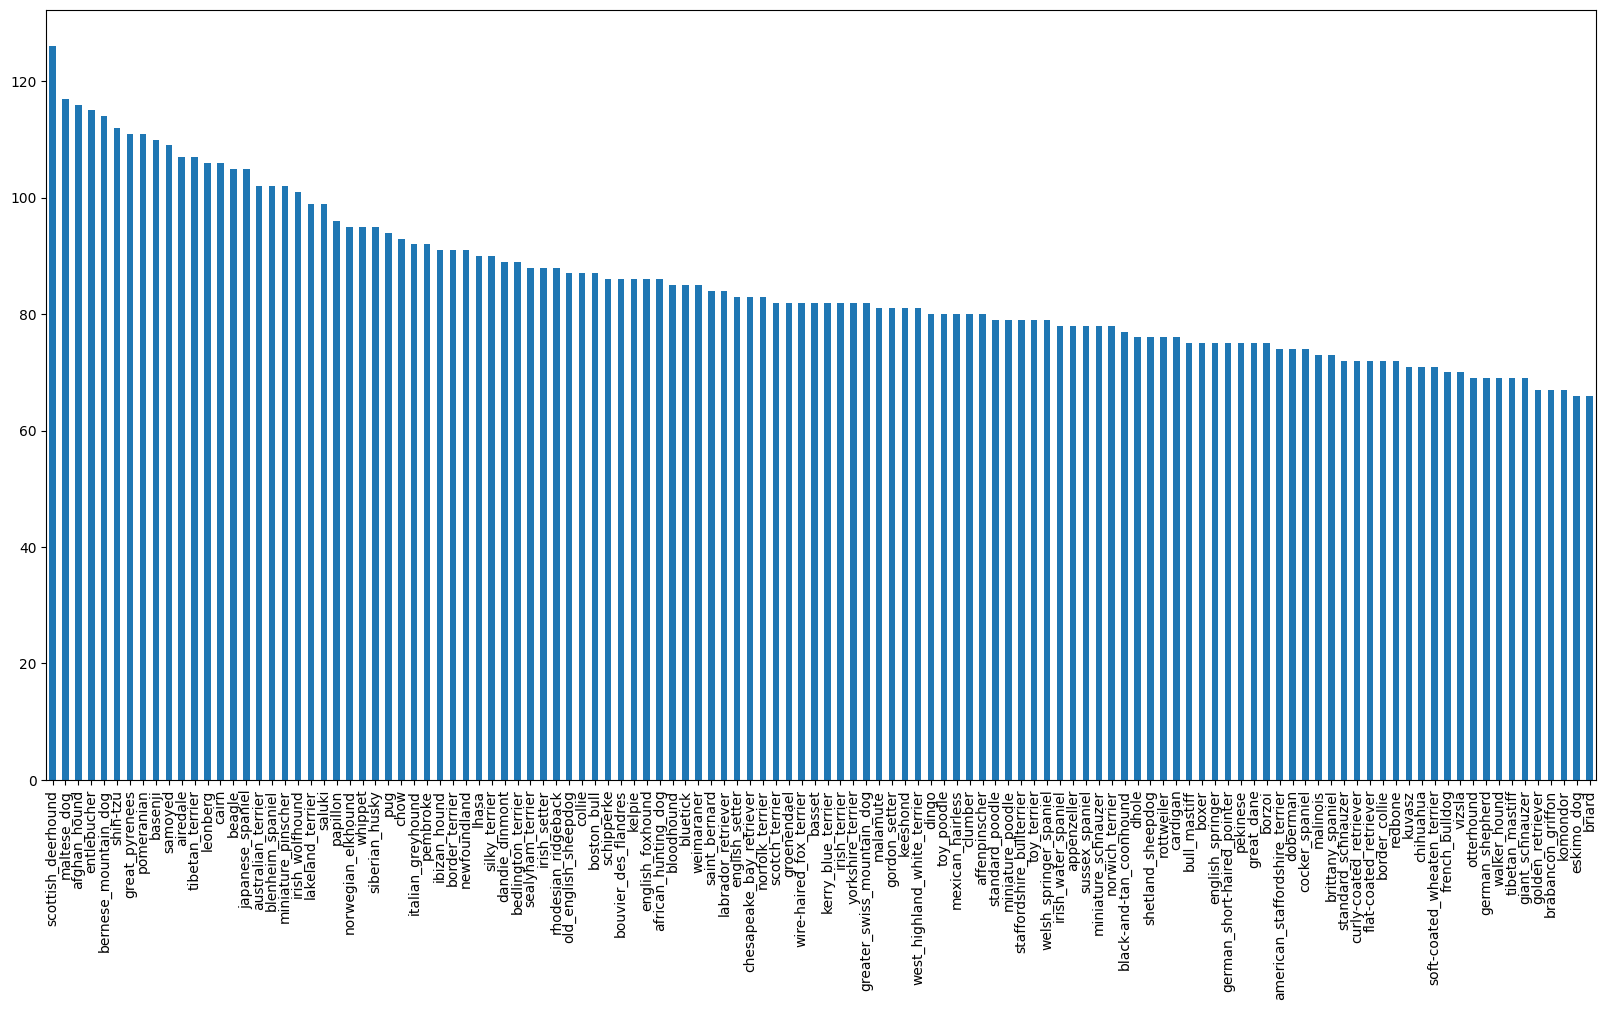

In [9]:
# How many images are tehere of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [10]:
labels_csv["breed"].value_counts().median()

82.0

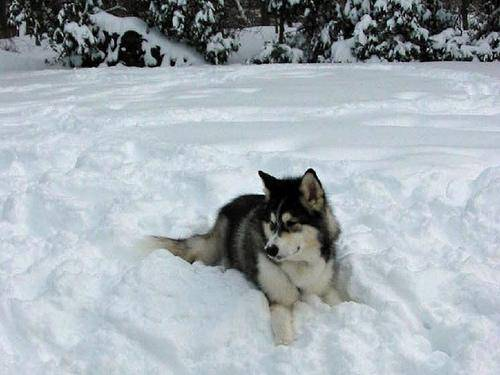

In [11]:
# Let's view images
from IPython.display import Image
Image("/content/train/185dd9ac0589562442f553cf686783d4.jpg")

# Getting images and their labels
 Let's get a list of all of our image file pathnames.


In [12]:
# Create pathnames from image Id's
filenames = ["/content/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/train"))==len(filenames):
  print("Filenames match actual amount of files !!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files !!! Proceed.


In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# lables = np;array(labels) # Does the same thing
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [16]:
len(labels)

10222

In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:

# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.


In [22]:
# Setup x & y variables
X = filenames
y = boolean_labels

In [23]:
len(filenames)

10222

We're going to start off experimenting with - 1000 images and increase as needed.


In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min: 1000, max:10000, step: 1000}

In [25]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [26]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['/content/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, F

# Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. use TensorFlow to read the file and save it to a vaatiable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (Convert color channel values from from 0-255 to 0-1).
4. Reize the `image` to be a shape of (224,224)
5. Return the modified `image`.

Before we do, let's see what Importing n image looks like

In [27]:
# Convert image to numpy arrray
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(), image.min()

(255, 0)

In [29]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [30]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [31]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

# Turning our datta into batches
Why turn our data inot batches?

Let's say you're tyring to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size)images at a time (can you manually adjust the batch size if need be).

In order to use tensorflow effectively, we need our data in the form of Tensor typles which look like this: `(image, label)`

In [32]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [33]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [34]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [35]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [36]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [37]:
import matplotlib.pyplot as plt

# Create a funciton for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and  their lables from a data batch.
  """
  # Setup tje figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5rows, 5columns)
    ax = plt.subplot(5,5,i+1)
    # display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [38]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [39]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

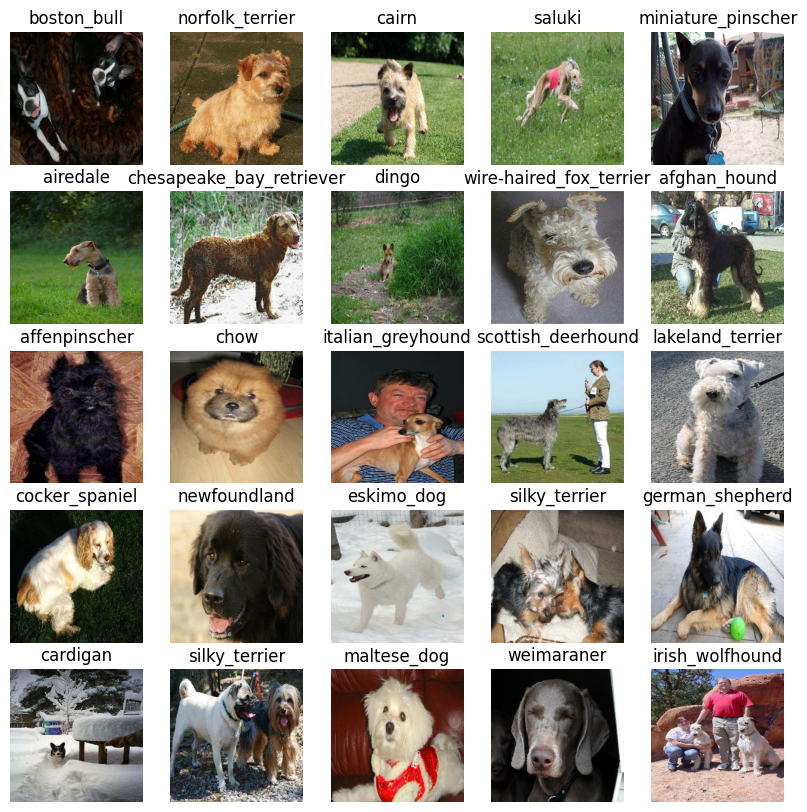

In [40]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

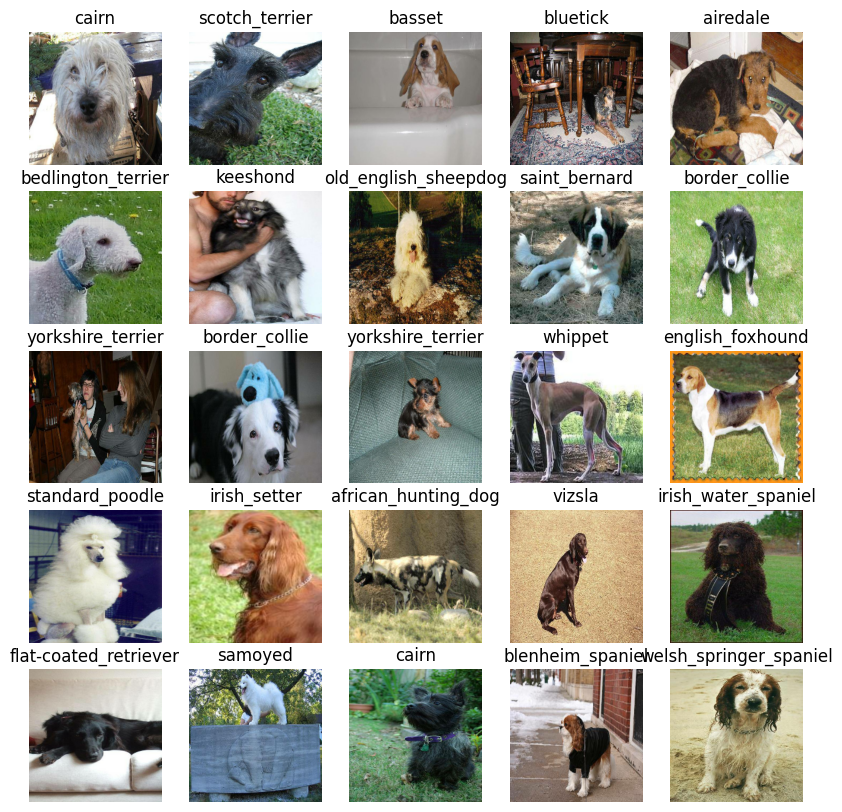

In [41]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Building a model
Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from tensorflow hub-
  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [42]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outpuuts and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in Keras model in sequential fashion(do this first, then this, then that).
* Compiles the model(says it should be evaluated and improved).
* Returns the model.

All of these staps can be found here: https://www.tensorflow.org/guide/keras/sequential_model

In [43]:
# Create a function which builds a Keras model
def create_model(input_shape= INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),  # Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  #Build the model
  model.build(INPUT_SHAPE)

  return model

In [44]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating Callbacks

Callbacks are helper funtions a model can use during training to do such things as save tis progress,, check its prgress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To Setup a TensorBoard callback, we need to do 3 things:
1. Load the TEnsorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [45]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [46]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard Logs
  logdir = os.path.join("/content/dog-breed-identification.ziplogs",
                        # Make it so the logs get tractked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops imporving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [47]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

# Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [48]:
NUM_EPOCHS = 100 # @param {type:"slider", min:10, max:100, step:10 }

Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit` function on our model passing it the training data, validation data, number oof epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [49]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new Tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  #return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 67s 3s/step - loss: 4.7363 - accuracy: 0.0838 - val_loss: 3.5058 - val_accuracy: 0.2300
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.6942 - accuracy: 0.6888

**QUESTION:** It looks like our model is overfitting becuase it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learninig newral netwroks?

**NOTE:** Overfitting to begin with is a good thing! It means our model is learning

## Checking the TensorBoard logs
the Tensorboard magic function (`%tensorboard) will access the logs directory we created earlier and visualize it's contents.

In [ ]:
%tensorboard --logdir /content/dog-breed-identification.ziplogs

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

In [ ]:
np.sum(predictions[0])

In [ ]:
# First prediction
index = 0
print(predictions[index])
print(f"Max Valua (probaility of predictions): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(predictions[index])]}")

Having the above funcitonality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**NOTE:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Turn predicion probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilites into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

Now since our validation data is still in a batch dataset, we'll hagve to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

Now we've got ways to get:
* Prediction labels
* Validation labels(truth labels)
* validation images

Let's make some function to make these all a bit more visualize.

We'll create a funciton which:
* Takes an array of probabilities, an array of turth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, it's predicted probability, the truth label and the target image on a single plot.


In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

ow we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using get_pred_label() ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some funciton to help us visualize our predictions and evaluate our model, let's check out some others

In [ ]:
# Let's check our a few predictions and their defferent values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels= val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """

  # Create a model directory pathname with current time
  modeldir= os.path.join("/content/dog-breed-identification.zipmodels",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('/content/dog-breed-identification.zipmodels/20240324-12221711282946-1000-images-mobilenetv2-Adam.h5')

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

## Training a big dog model (on the full dataset)

In [ ]:
len(X), len(y)

In [ ]:
# Create a data batch with full data set
full_data = create_data_batches(X, y)

In [ ]:
full_data

In [ ]:
full_model = create_model()

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

In [ ]:
loaded_full_model = load_model('/content/dog-breed-identification.zipmodels/20240324-12391711283987-full-image-set-mobilenetv2-Adam.h5')

## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenmes as input and conver them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data baches using `create_data_baches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictioins array by passing the test batches to the `predict()` method called on our model

In [ ]:
# Load test image filenames
test_path = "/content/test/"
test_filenames = [test_path+fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [ ]:
test_data

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr)

In [ ]:
# Check out the test predictions
test_predictions[:10]

## Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"]+ list(unique_breeds))
preds_df.head()

In [ ]:
 # Append test image Id's to predictions DataFrame
 test_ids = [os.path.splitext(path) for path in os.listdir(test_path)]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("/content/sample_submission.csv",
                index=False)

# Making predictions on custom images
It's great being able to make predictions on a test dataset already provided for us.

But how could we use our model on our own images?

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches(). `And since our custom images won't have labels, we set the `test_data `parameter to `True.`
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

**Note:** To make predictions on custom images, I've uploaded pictures of my own to a directory located at `drive/My Drive/Data/dogs/` (as seen in the cell below). In order to make predictions on your own images, you will have to do something similar.

In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/dog-vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
custom_preds.shape

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i])for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() fucntion won't work since there aren't lebls...)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)
